<a href="https://colab.research.google.com/github/17092003vamsi/HUNTERs/blob/main/HUNTER_2026%20gg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

🔹 RandomForest Results:
✅ Accuracy: 0.727
✅ ROC-AUC: 0.620
              precision    recall  f1-score   support

           0       0.50      0.41      0.45        27
           1       0.79      0.85      0.82        72

    accuracy                           0.73        99
   macro avg       0.65      0.63      0.63        99
weighted avg       0.71      0.73      0.72        99



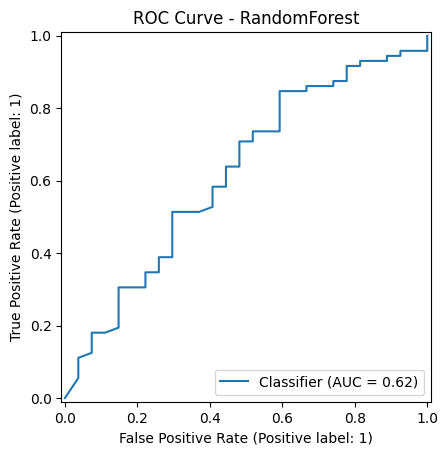


🔹 LogisticRegression Results:
✅ Accuracy: 0.616
✅ ROC-AUC: 0.677
              precision    recall  f1-score   support

           0       0.37      0.59      0.46        27
           1       0.80      0.62      0.70        72

    accuracy                           0.62        99
   macro avg       0.59      0.61      0.58        99
weighted avg       0.69      0.62      0.64        99



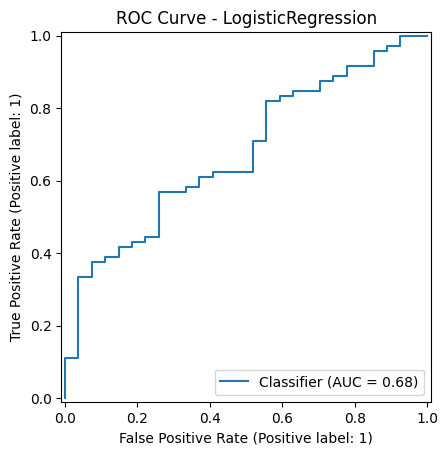


🔹 SVM Results:
✅ Accuracy: 0.596
✅ ROC-AUC: 0.687
              precision    recall  f1-score   support

           0       0.37      0.67      0.47        27
           1       0.82      0.57      0.67        72

    accuracy                           0.60        99
   macro avg       0.59      0.62      0.57        99
weighted avg       0.70      0.60      0.62        99



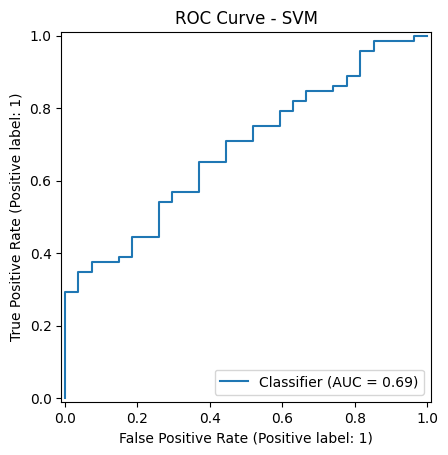

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:42:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 XGBoost Results:
✅ Accuracy: 0.677
✅ ROC-AUC: 0.658
              precision    recall  f1-score   support

           0       0.39      0.33      0.36        27
           1       0.76      0.81      0.78        72

    accuracy                           0.68        99
   macro avg       0.58      0.57      0.57        99
weighted avg       0.66      0.68      0.67        99



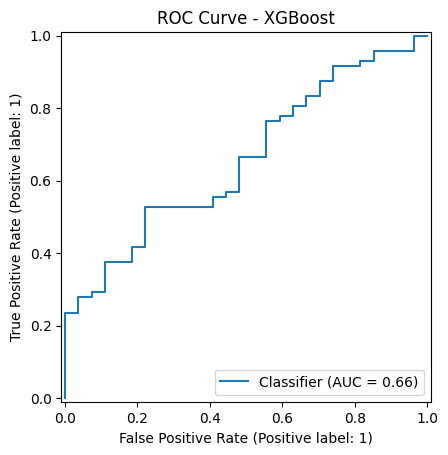


🏆 Best model: SVM (ROC-AUC = 0.687)

🔎 Running LIME explainability on best model...

✅ LIME explanation for patient 0:


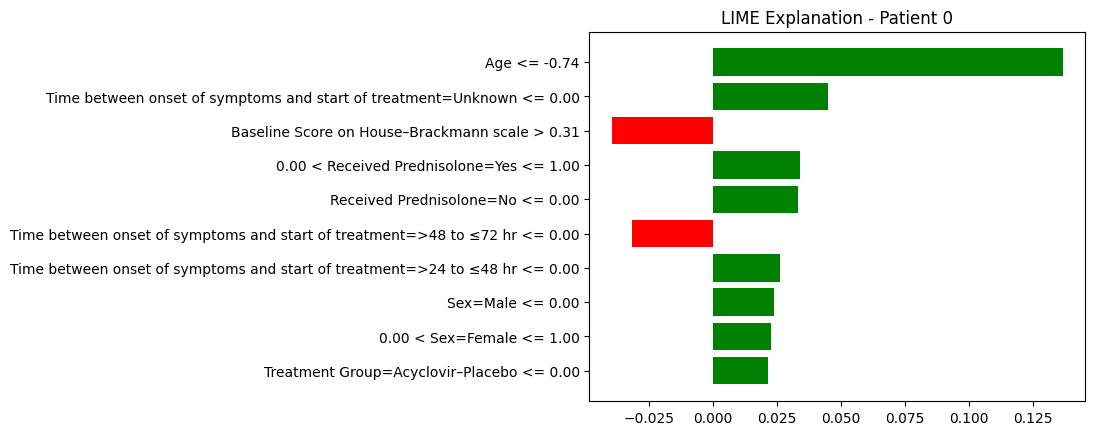


✅ LIME explanation for patient 1:


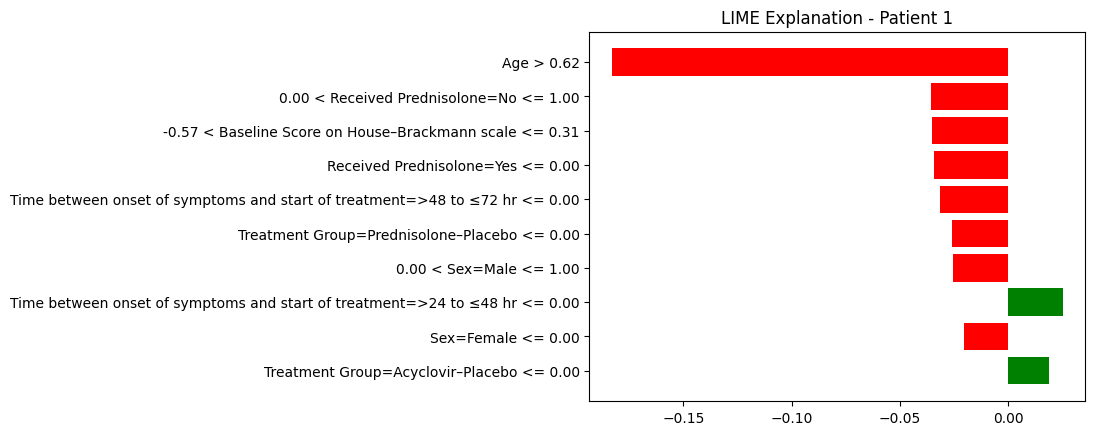


✅ LIME explanation for patient 2:


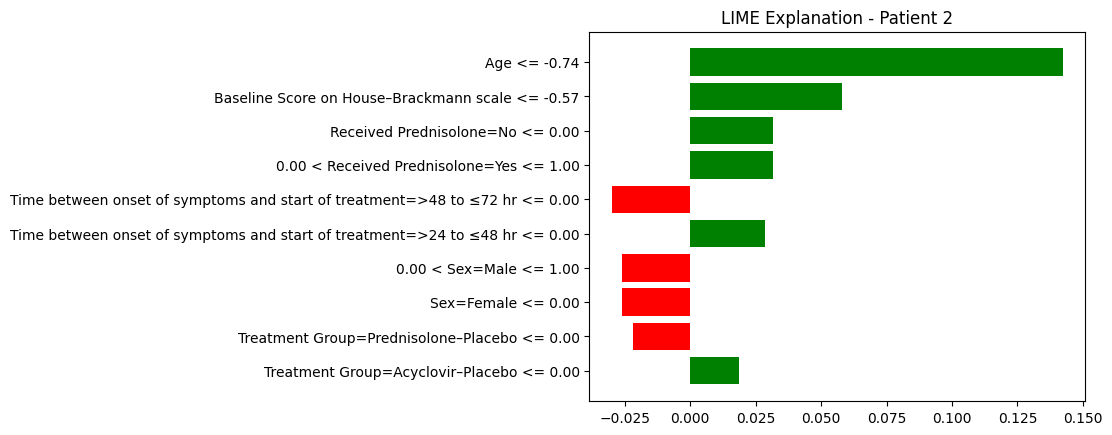


💾 Best model saved as bells_palsy_best_model_SVM_LIME.joblib


In [5]:
# ✅ Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn joblib lime xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib

from lime.lime_tabular import LimeTabularExplainer


# 1. Load Dataset
df = pd.read_csv("Bells Palsy Clinical Trial.csv")

# Target column
target_col = "Full Recovery in 3 Months"
y = df[target_col].map({"Yes": 1, "No": 0})

# Features
features = [
    'Sex',
    'Age',
    'Baseline Score on House–Brackmann scale',
    'Time between onset of symptoms and start of treatment',
    'Treatment Group',
    'Received Prednisolone',
    'Received Acyclovir',
]
X = df[features].copy()


# 2. Preprocessing
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


# 3. Define Models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}


# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 5. Train and Evaluate
results = {}

for name, model in models.items():
    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results[name] = {"Accuracy": acc, "ROC-AUC": auc, "Model": clf}

    print(f"\n🔹 {name} Results:")
    print(f"✅ Accuracy: {acc:.3f}")
    print(f"✅ ROC-AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve - {name}")
    plt.show()


# 6. Pick Best Model
best_model_name = max(results, key=lambda x: results[x]["ROC-AUC"])
best_model = results[best_model_name]["Model"]
print(f"\n🏆 Best model: {best_model_name} (ROC-AUC = {results[best_model_name]['ROC-AUC']:.3f})")


# 7. Feature Names (after preprocessing)
def get_feature_names(preprocess, numeric_cols, categorical_cols):
    feat_names = numeric_cols.copy()
    ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
    for col, cats in zip(categorical_cols, ohe.categories_):
        feat_names.extend([f"{col}={cat}" for cat in cats])
    return feat_names

feat_names = get_feature_names(preprocess, numeric_cols, categorical_cols)


# 8. 🔎 LIME Explainability
print("\n🔎 Running LIME explainability on best model...")

# Extract transformed train/test data
pre = best_model.named_steps["preprocess"]
model_used = best_model.named_steps["model"]

X_train_transformed = pre.transform(X_train)
X_test_transformed = pre.transform(X_test)

# Initialize LIME Explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_transformed),
    feature_names=feat_names,
    class_names=["No Recovery", "Recovery"],
    mode="classification"
)

# Explain first 3 patients
for sample_idx in range(3):
    exp = explainer.explain_instance(
        data_row=X_test_transformed[sample_idx],
        predict_fn=model_used.predict_proba
    )

    print(f"\n✅ LIME explanation for patient {sample_idx}:")
    exp.show_in_notebook(show_table=True)
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation - Patient {sample_idx}")
    plt.show()


# 9. Save Best Model
joblib.dump(best_model, f"bells_palsy_best_model_{best_model_name}_LIME.joblib")
print(f"\n💾 Best model saved as bells_palsy_best_model_{best_model_name}_LIME.joblib")
